## Policy Iteration (2 step)
- Policy Evaluation
- Policy Improvement

In [2]:
import gym
%matplotlib inline

In [3]:
env = gym.make("FrozenLake8x8-v0")

obs_space = env.observation_space
n_state = obs_space.n
print("Observation space's total states :", n_state)

act_space = env.action_space
n_act = act_space.n
print("Action space's total actions :", n_act)

# Transition Matrix for FrozenLake
P = env.unwrapped.P
env.render() # show

Observation space's total states : 64
Action space's total actions : 4

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### Define functions step by step
#### Initial Policy : $\pi_0 (\centerdot| s)$

Initial Policy Distribution : 



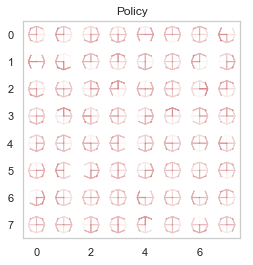

[[0.348 0.208 0.099 0.344]
 [0.466 0.132 0.114 0.288]
 [0.124 0.36  0.333 0.183]
 [0.236 0.345 0.274 0.145]
 [0.433 0.01  0.463 0.094]
 [0.358 0.046 0.316 0.281]
 [0.176 0.281 0.166 0.377]
 [0.541 0.307 0.151 0.   ]
 [0.552 0.004 0.426 0.018]
 [0.396 0.532 0.016 0.056]
 [0.377 0.061 0.229 0.332]
 [0.221 0.138 0.193 0.448]
 [0.156 0.397 0.064 0.382]
 [0.216 0.305 0.159 0.32 ]
 [0.466 0.101 0.053 0.38 ]
 [0.022 0.344 0.403 0.231]
 [0.315 0.434 0.101 0.15 ]
 [0.332 0.284 0.296 0.089]
 [0.081 0.205 0.402 0.312]
 [0.37  0.032 0.109 0.489]
 [0.381 0.17  0.397 0.052]
 [0.284 0.264 0.146 0.307]
 [0.194 0.047 0.589 0.171]
 [0.334 0.105 0.153 0.407]
 [0.162 0.348 0.273 0.216]
 [0.091 0.111 0.26  0.538]
 [0.413 0.289 0.126 0.171]
 [0.338 0.209 0.16  0.294]
 [0.051 0.355 0.377 0.217]
 [0.195 0.106 0.142 0.557]
 [0.054 0.225 0.335 0.387]
 [0.184 0.157 0.248 0.411]
 [0.062 0.363 0.313 0.262]
 [0.242 0.317 0.084 0.356]
 [0.387 0.281 0.276 0.056]
 [0.322 0.302 0.032 0.344]
 [0.096 0.372 0.299 0.232]
 

In [4]:
def plot_policy(policy):
    plt.figure(num=0)
    plt.imshow(np.ones((8,8,3)))
    plt.title("Policy")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.grid(False)
    plt.show()
    
policy = np.random.uniform(size=(n_state,n_act)) # 0~1사이의 숫자 random sampling
policy = policy/np.sum(policy, axis=1, keepdims=True) # 합이 1이 되도록 만들어준다.

np.set_printoptions(precision=3, suppress=True)
print("Initial Policy Distribution : \n")
plot_policy(policy)
print(policy)

### Policy Evaluation
: policy($\pi$)를 고정하고, 전체 state의 value function을 계산한다. <br>
: 아래의 식을 활용 <br>
$$V_{\pi}(s) = \sum_a \pi(a|s)\sum_{s'} [r(s,a,s') + \gamma V_{\pi}(s')]P(s'|s,a)$$

In [5]:
P.keys() # all state

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [6]:
P[0].keys() # all action in state 0

dict_keys([0, 1, 2, 3])

In [7]:
P[0][1]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 8, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

Policy Evaluation for random policy 

Value of current policy


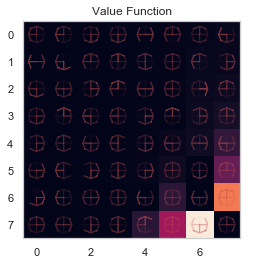

In [8]:
def policy_evaluation(env, policy, gamma=0.99, epsilon=1e-6):
    """
    gamma : discount factor
    epsilon : terminal condition(이것보다 작아지면 break하여 optimal추출)
    """
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P
    
    # Random initialize the Value (function)
    v = np.random.uniform(size=(n_state,1))
    
    while True:
        v_prime = np.zeros((n_state,))
        for s in P.keys():
            for a in P[s].keys():
                for prob, next_s, reward, done in P[s][a]:
                    v_prime[s] += policy[s][a] * (reward + gamma*v[next_s]) * prob # 지금 가지고 있는 policy를 가지고 value를 뽑고
        
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def plot_results(policy, value): 
    # policy visualization
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title("Value Function")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.grid(False)
    plt.show()

if __name__=='__main__':
    print("Policy Evaluation for random policy \n")
    value = policy_evaluation(env, policy=policy, gamma=0.99, epsilon=1e-6)
    print("Value of current policy")
    plot_results(policy=policy, value=value)
    
    # policy 초기값 넣어 한번 evaluation하고 시각화

### Policy Improvement
: Policy Evaluation에서 계산된 value가지고, Policy($\pi$)를 업데이트하자.<br>
: 새로운 policy는 greed하게 업데이트된다. <br>

\DeclareMathOperator*{\argmax}{arg\,max}

$$ \\ Q_{\pi_i}(s,a) = \sum_{s'}[r(s,a,s') + \gamma V_{\pi_i}(s')]P(s'|s,a) \\$$
$$\pi_{i+1} = argmax_a Q_{\pi_i}(s,a)$$

Policy improvement 

Improved Policy


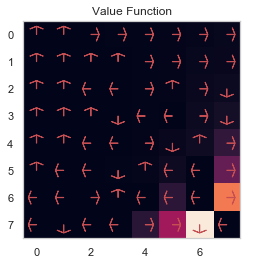

In [9]:
def policy_improvement(env, v, gamma=0.99):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    q = np.zeros((n_state,n_act))
    
    for s in P.keys():
        for a in P[s].keys():
            for prob, next_s, reward, done in P[s][a]:
                q[s][a] += (reward + gamma*v[next_s])*prob
                
    policy = np.zeros((n_state, n_act))
    # 모든 state의 expected return(q값)이 제일 큰 action의 probability를 1로 만든다.
    policy[np.arange(n_state), np.argmax(q,axis=1)] = 1 
    
    return policy

if __name__=='__main__':
    print("Policy improvement \n")
    policy = policy_improvement(env, value) # 위에서 선언한 value
    print("Improved Policy")
    plot_results(policy=policy, value=value)

이게 최초 업데이트된 상태의 policy <br>
이제 이걸 iteration시킨다.(반복)

### Policy Iteration
Policy iteration algorithm consists of four steps: <br>
<br>
(1) Initial policy distribution is randomly initialized <br>
<br>
(2) Value function for current policy is computed by policy evaluation <br>
<br>
(3) Policy distribution is greedily updated using value function from (2) <br>
<br>
(4) If policy distribution doesn't change, then stop. Othrewise, repeat (1) ~ (3) <br>

Policy Iteration
complete the iteration, find the optimal policy!!
Computation Time : 23.39


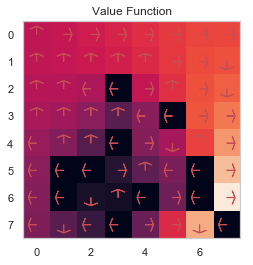

In [10]:
def policy_iteration(env):
    # initial policy setting
    policy = np.random.uniform(size=(n_state, n_act))
    policy = policy / np.sum(policy, axis=1, keepdims=True)
    
    while True:
        # policy evaluation
        value = policy_evaluation(env, policy)
        # policy improvement
        policy_prime = policy_improvement(env, value)
        
        if (policy == policy_prime).all(): # it means 'nothing changed'
            print("complete the iteration, find the optimal policy!!")
            break
        policy = policy_prime # update new policy
    
    return policy, value

if __name__=='__main__':
    print("Policy Iteration")
    import time
    start = time.time()
    policy, value = policy_iteration(env)
    print("Computation Time : %.2f"%(time.time() - start))
    plot_results(policy, value)

### Run Optimal Policy

In [11]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

t = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 2
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 3
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 4
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 5
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 6
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 7
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 8
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 9
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 10
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 11
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFF

time step = 45만에 목표지점 도착!